In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.pyplot as plt
import xarray as xr

import numpy as np
import metpy
import metpy.calc as mpcalc
from metpy.plots import ctables
from metpy.cbook import get_test_data
from metpy.units import units
import os
import scipy.integrate as integrate
import datetime as dt
import glob
import json
from datetime import datetime
from datetime import timedelta
from metpy.plots import ctables
from matplotlib.colors import Normalize
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, BoundaryNorm

#import wrf
import scipy
#import xcape
import xarray
import Magics.macro as magics

In [2]:
file_dir = '/data/icond2/'
os.chdir(file_dir)

data_det_vmax = xr.open_dataset('icond2_vmax.nc').sel(lon=slice(363,369,1),lat=slice(49,51,1))

file_dir = '/data/icond2eps/'
os.chdir(file_dir)

data = xarray.open_dataset('icond2eps_vmax_latlon.grib2', engine='cfgrib')
data.to_netcdf('icond2eps_gust.nc')
data_gust = xr.open_dataset('icond2eps_gust.nc').sel(longitude=slice(3,9,1),latitude=slice(49,51,1))

print(data_det_vmax)
print(data_gust)

Ignoring index file 'icond2eps_vmax_latlon.grib2.923a8.idx' older than GRIB file


<xarray.Dataset>
Dimensions:   (time: 48, lon: 301, lat: 101, height: 1)
Coordinates:
  * time      (time) datetime64[ns] 2022-02-17T16:00:00 ... 2022-02-19T15:00:00
  * lon       (lon) float32 363.0 363.0 363.0 363.1 ... 368.9 369.0 369.0 369.0
  * lat       (lat) float32 49.0 49.02 49.04 49.06 ... 50.94 50.96 50.98 51.0
  * height    (height) float64 10.0
Data variables:
    VMAX_10M  (time, height, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version ?? (http://mpimet.mpg.de/cdi)
    Conventions:  CF-1.6
    history:      Thu Feb 17 16:43:15 2022: cdo -f nc copy icond2_vmax_new.gr...
    institution:  Deutscher Wetterdienst
    CDO:          Climate Data Operators version 1.9.3 (http://mpimet.mpg.de/...
<xarray.Dataset>
Dimensions:            (longitude: 301, latitude: 100, step: 49, number: 20)
Coordinates:
  * longitude          (longitude) float64 3.0 3.02 3.04 3.06 ... 8.96 8.98 9.0
  * latitude           (latitude) float64 49.0 49.02 49.04 ... 50.9

In [3]:
# To parse the full dataset, we can call parse_cf without an argument, and assign the returned Dataset.

data_gust = data_gust.metpy.parse_cf()
data_det_vmax = data_det_vmax.metpy.parse_cf()

x, y = data_gust['gust'].metpy.coordinates('x', 'y')

time = data_gust['gust'].step
member = data_gust['gust'].number
#time2 = data_det_rr['tp'].metpy.time

timeinit = data_gust.time
timeinit = datetime.utcfromtimestamp(timeinit.item()/1e9)
print(timeinit)

#uh = data_uh['UH_MAX']
vmax = data_gust['gust']
#rr = data_rr['tp']
#det_rr = data_det_rr['tp']
det_gust = data_det_vmax['VMAX_10M']
#det_uh = data_det_uhmax['UH_MAX']

#rr.data = np.nan_to_num(rr.data, copy=True, nan=0)
print(np.shape(vmax.data))

#vmax_median = np.percentile(vmax, 50)
vmax_median = np.empty((49,100,301))
vmax_95 = np.empty((49,100,301))

for i in range(0,49):
    for j in range (0,100):
        for k in range(0,301):
            vmax_median[i,j,k] = np.percentile(vmax.data[:,i,j,k],50)

print(np.shape(vmax_median))

for i in range(0,49):
    for j in range (0,100):
        for k in range(0,301):
            vmax_95[i,j,k] = np.percentile(vmax.data[:,i,j,k],95)

/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/metpy/xarray.py:349: UserWarning: More than one time coordinate present for variable "gust".
  warnings.warn('More than one ' + axis + ' coordinate present for variable'
Found valid latitude/longitude coordinates, assuming latitude_longitude for projection grid_mapping variable
Found valid latitude/longitude coordinates, assuming latitude_longitude for projection grid_mapping variable


2022-02-17 15:00:00
(20, 49, 100, 301)
(49, 100, 301)


In [4]:
def plot_background(ax):
    ax.set_extent([5, 7, 49.1, 50.5])
    ax.add_feature(cfeature.COASTLINE.with_scale('10m'), LineWidth=2)
    ax.add_feature(cfeature.BORDERS.with_scale('10m'),LineWidth=2)
    #gl = ax.gridlines(draw_labels=True,linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    #gl.xlabels_top = False
    #gl.ylabels_right = False
    #gl.xlabel_style = {'size': 12, 'color': 'black'}
    #gl.ylabel_style = {'size': 12, 'color': 'black'}
    #gl.xformatter = LONGITUDE_FORMATTER
    #gl.yformatter = LATITUDE_FORMATTER
    return ax

#import matplotlib
#cmap = matplotlib.cm.get_cmap('cubehelix_r')
#for i in range(20):
    #rgba = cmap(i)
    # rgb2hex accepts rgb or rgba
    #print(rgba)
    
cmap = ctables.colortables.get_colortable('NWSStormClearReflectivity')
newcmap = ListedColormap(cmap(np.linspace(0.25, 0.92, 28)))

cmap2 = ctables.colortables.get_colortable('NWSReflectivity')
newcmap2 = ListedColormap(cmap2(np.linspace(0.2, 0.96, 28)))

cmap4 = ctables.colortables.get_colortable('precipitation')
newcmap4 = ListedColormap(cmap4(np.linspace(0, 0.75, 15)))

colors=[(1,1,1),(0.0, 0.9254901960784314, 0.9254901960784314), 
                        (0.00392156862745098, 0.6274509803921569, 0.9647058823529412), 
                        (0.0, 0.0, 0.9647058823529412), 
                        (0.0, 1.0, 0.0), 
                        (0.0, 0.7843137254901961, 0.0), 
                        (0.0, 0.5647058823529412, 0.0), 
                        (1.0, 1.0, 0.0), 
                        (0.9058823529411765, 0.7529411764705882, 0.0), 
                        (1.0, 0.5647058823529412, 0.0), 
                        (1.0, 0.16078431372, 0.16078431372), 
                        (0.7529411764705882, 0.0, 0.0),
                        (0.59765625, 0.0, 0.0), 
                        (1.0, 0.0, 1.0), 
                        (0.6, 0.3333333333333333, 0.788235294117647),
                         (0.27,0,0.4)]
colors2 = [(1,1,1),
           (0.388235, 0.462745, 0.658824), (0.372549, 0.45098, 0.654902), (0.372549, 0.45098, 0.654902), 
           (0.356863, 0.439216, 0.65098), (0.341176, 0.427451, 0.643137), (0.32549, 0.415686, 0.639216), 
           (0.309804, 0.403922, 0.635294), (0.294118, 0.392157, 0.631373), (0.278431, 0.380392, 0.627451), 
           (0.262745, 0.368627, 0.623529), (0.262745, 0.380392, 0.635294), (0.270588, 0.407843, 0.65098), 
           (0.282353, 0.435294, 0.666667), (0.290196, 0.462745, 0.682353), (0.301961, 0.490196, 0.698039), 
           (0.309804, 0.517647, 0.713725), (0.317647, 0.545098, 0.733333), (0.329412, 0.572549, 0.74902), 
           (0.337255, 0.6, 0.764706), (0.34902, 0.623529, 0.780392), (0.356863, 0.65098, 0.796078), 
           (0.368627, 0.678431, 0.811765), (0.376471, 0.705882, 0.831373), (0.384314, 0.733333, 0.847059), 
           (0.396078, 0.760784, 0.862745), (0.403922, 0.788235, 0.878431), (0.415686, 0.815686, 0.894118),
           (0.435294, 0.839216, 0.909804), (0.407843, 0.839216, 0.843137), (0.380392, 0.839216, 0.772549), 
           (0.34902, 0.839216, 0.701961), (0.321569, 0.839216, 0.635294), (0.294118, 0.839216, 0.564706), 
           (0.262745, 0.839216, 0.494118), (0.235294, 0.839216, 0.427451), (0.207843, 0.839216, 0.356863),
           (0.066667, 0.835294, 0.094118), (0.066667, 0.819608, 0.090196), (0.062745, 0.803922, 0.090196), 
           (0.062745, 0.784314, 0.086275), (0.062745, 0.768627, 0.086275), (0.058824, 0.752941, 0.082353), 
           (0.058824, 0.737255, 0.082353), (0.058824, 0.717647, 0.078431), (0.054902, 0.701961, 0.078431), 
           (0.054902, 0.686275, 0.07451), (0.054902, 0.670588, 0.07451), (0.05098, 0.65098, 0.070588), 
           (0.05098, 0.635294, 0.070588), (0.05098, 0.619608, 0.066667), (0.047059, 0.6, 0.066667), 
           (0.047059, 0.584314, 0.062745), (0.047059, 0.568627, 0.062745), (0.043137, 0.552941, 0.058824),
           (0.043137, 0.533333, 0.058824), (0.043137, 0.517647, 0.054902), (0.039216, 0.501961, 0.054902),
           (0.039216, 0.486275, 0.05098), (0.039216, 0.466667, 0.05098), (0.035294, 0.45098, 0.047059), 
           (0.035294, 0.435294, 0.047059), (0.035294, 0.419608, 0.043137), (0.031373, 0.4, 0.043137),
           (0.031373, 0.384314, 0.039216), (0.035294, 0.368627, 0.035294), (0.113725, 0.407843, 0.035294), 
           (0.196078, 0.45098, 0.031373), (0.27451, 0.490196, 0.031373), (0.356863, 0.533333, 0.027451), 
           (0.435294, 0.572549, 0.027451), (0.517647, 0.615686, 0.023529), (0.596078, 0.658824, 0.023529),
           (0.678431, 0.698039, 0.019608), (0.756863, 0.741176, 0.019608), (0.839216, 0.780392, 0.015686),
           (0.917647, 0.823529, 0.015686), (1.0, 0.886275, 0.0), (1.0, 0.847059, 0.0), (1.0, 0.827451, 0.0), 
           (1.0, 0.788235, 0.0), (1.0, 0.768627, 0.0), (1.0, 0.733333, 0.0), (1.0, 0.713725, 0.0), 
           (1.0, 0.693725, 0.0), (1.0, 0.67451, 0.0), (1.0, 0.654902, 0.0), (1.0, 0.619608, 0.0), 
           (1.0, 0.6, 0.0), (1.0, 0.580392, 0.0), (1.0, 0.541176, 0.0), (1.0, 0.521569, 0.0), 
           (1.0, 0.501569, 0.0), (0.945098, 0.0, 0.0), 
           (0.917647, 0.0, 0.0), (0.890196, 0.0, 0.0), (0.862745, 0.0, 0.0), (0.835294, 0.0, 0.0), 
           (0.803922, 0.0, 0.0), (0.776471, 0.0, 0.0), (0.74902, 0.0, 0.0), (0.721569, 0.0, 0.0), 
           (0.694118, 0.0, 0.0), (0.666667, 0.0, 0.0), (0.639216, 0.0, 0.0), (0.607843, 0.0, 0.0),
           (0.580392, 0.0, 0.0), (0.552941, 0.0, 0.0), (0.52549, 0.0, 0.0), (0.498039, 0.0, 0.0), 
           (0.470588, 0.0, 0.0), (0.443137, 0.0, 0.0), (1.0, 0.960784, 1.0), 
           (1.0, 0.917647, 1.0), (1.0, 0.87451, 1.0), (1.0, 0.831373, 1.0), (1.0, 0.788235, 1.0), 
           (1.0, 0.745098, 1.0), (1.0, 0.701961, 1.0), (1.0, 0.658824, 1.0), (1.0, 0.615686, 1.0), 
           (1.0, 0.572549, 1.0), (1.0, 0.458824, 1.0), (0.988235, 0.419608, 0.992157), 
           (0.976471, 0.376471, 0.980392), (0.964706, 0.337255, 0.968627), (0.952941, 0.294118, 0.956863), 
           (0.941176, 0.25098, 0.945098), (0.929412, 0.211765, 0.937255), (0.917647, 0.168627, 0.92549), 
           (0.905882, 0.12549, 0.913725), (0.894118, 0.086275, 0.901961), (0.882353, 0.043137, 0.890196), 
           (0.698039, 0.0, 1.0), (0.67451, 0.0, 0.988235), (0.643137, 0.0, 0.968627), (0.607843, 0.0, 0.956863),
           (0.576471, 0.0, 0.937255), (0.533333, 0.0, 0.917647), (0.513725, 0.0, 0.909804),
           (0.47451, 0.0, 0.886275), (0.447059, 0.0, 0.866667), (0.411765, 0.0, 0.858824), 
           (0.388235, 0.0, 0.839216)]

colors3 = [(1,1,1), (0.961,0.949,0.847),
          (0.886,0.933,0.776),
          (0.776,0.910,0.737),
           (0.643,0.878,0.718),
          (0.494,0.835,0.722),
          (0.341,0.784,0.737),
          (0.204,0.722,0.753),
          (0.180,0.647,0.761),
          (0.278,0.557,0.757),
          (0.392,0.455,0.725),
          (0.478,0.333,0.671),
          (0.518,0.208,0.565),
          (0.502,0.078,0.431)]

cmap1 = ListedColormap(colors)
newcmap1 = ListedColormap(cmap1(np.linspace(0, 1, 17)))

cmap3 = ListedColormap(colors3)
newcmap3 = ListedColormap(cmap3(np.linspace(0, 1, 14)))
bounds = [0,0.1,0.5,1,3,5,10,15,20,25,30,35,40,45,50,55]
norm = BoundaryNorm(bounds, newcmap4.N)
bounds6 = [0,0.1,5,10,15,20,25,30,40,50,60,70,80,90,100,110]
norm6 = BoundaryNorm(bounds6, newcmap4.N)
bounds24 = [0,0.1,5,10,20,30,40,50,60,70,80,90,100,110,120,130]
norm24 = BoundaryNorm(bounds6, newcmap4.N)

#cmap2 = ListedColormap(colors2)
#newcmap2 = ListedColormap(cmap2(np.linspace(0, 0.9, 29)))

NameError: name 'plot_background' is not defined

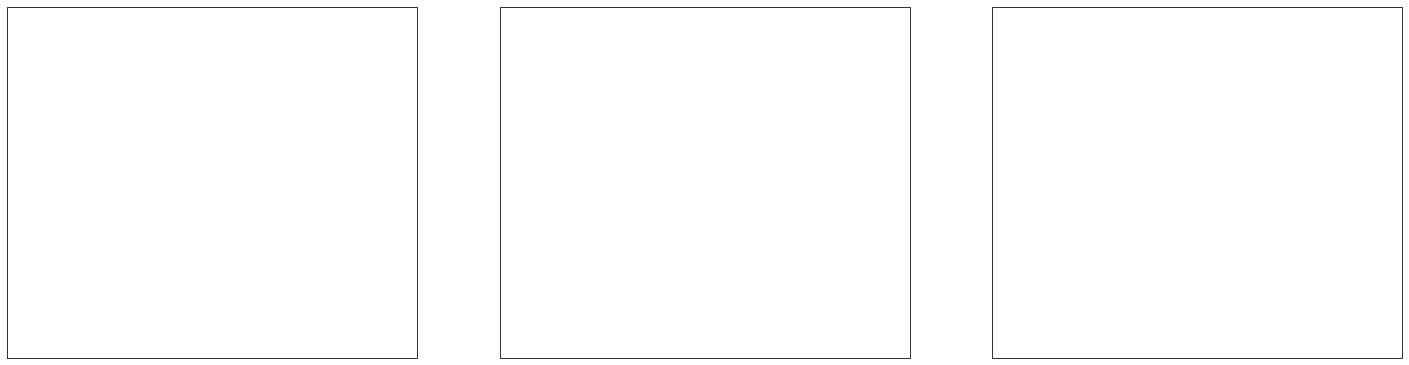

In [31]:
# Create the figure and plot background on different axes
crs = ccrs.Mercator()

for i in range(1,49):
    
    fig, axarr = plt.subplots(nrows=1, ncols=3, figsize=(25, 10), constrained_layout=False,
                  subplot_kw={'projection': crs})
    # Set height padding for plots
    fig.set_constrained_layout_pads(w_pad=0., h_pad=10, hspace=0., wspace=0.)
    
    axlist = axarr.flatten()
    
    for ax in axlist:
        plot_background(ax)
        
    timestep=timeinit+timedelta(hours=i)
    time2 = data_det_vmax['VMAX_10M'].metpy.time
    clevs_gust = np.arange(10,150,10)
    # cmap = plt.get_cmap('gist_ncar')
    # newcmap = ListedColormap(cmap(np.linspace(0.15, 0.9, 30)))
        
    # Upper left plot
    cf1 = axlist[0].contourf(data_gust.longitude, data_gust.latitude, vmax_median[i,:,:]*3.6, 
                      clevs_gust, cmap='CMRmap_r', extend='max',transform=ccrs.PlateCarree())
    ccf1= axlist[0].contour(data_gust.longitude, data_gust.latitude,  vmax_median[i,:,:]*3.6,
                     [30,50,70,90,110,130], colors='dimgrey', linestyles="dotted",transform=ccrs.PlateCarree())
    axlist[0].clabel(ccf1, fontsize=10, inline=1, inline_spacing=1, fmt='%i', rightside_up=True)
    axlist[0].set_title('50th Percentile (Median)', fontsize=16)
    #cb1= fig.colorbar(cf1, ax=axlist[0], orientation='vertical', 
                     # ticks=(10,20,30,40,50,60,70,80,90,100,110,120,130),
                            #  shrink=0.73, fraction=0.1, pad=0)
    #cb1.set_label('km/h', size='x-large')
    
    cf2 = axlist[1].contourf(data_gust.longitude, data_gust.latitude, vmax_95[i,:,:]*3.6, 
                      clevs_gust, cmap='CMRmap_r', extend='max',transform=ccrs.PlateCarree())
    ccf2= axlist[1].contour(data_gust.longitude, data_gust.latitude,  vmax_95[i,:,:]*3.6,
                     [30,50,70,90,110,130], colors='dimgrey', linestyles="dotted",transform=ccrs.PlateCarree())
    axlist[1].clabel(ccf2, fontsize=10, inline=1, inline_spacing=1, fmt='%i', rightside_up=True)
    axlist[1].set_title('95th Percentile', fontsize=16)
    #cb2= fig.colorbar(cf2, ax=axlist[1], orientation='vertical', 
                      #ticks=(10,20,30,40,50,60,70,80,90,100,110,120,130),
                             # shrink=0.73, fraction=0.1, pad=0)
   # cb2.set_label('km/h', size='x-large')

    cf3 = axlist[2].contourf(data_det_vmax.lon-360, data_det_vmax.lat, det_gust.metpy.loc[{'time': time2[i-1], 'height': 10}]*3.6, 
                          clevs_gust, cmap='CMRmap_r', extend='max',transform=ccrs.PlateCarree())
    ccf3= axlist[2].contour(data_det_vmax.lon-360, data_det_vmax.lat, det_gust.metpy.loc[{'time': time2[i-1], 'height':10}]*3.6,
                     [30,50,70,90,110,130], colors='dimgrey', linestyles="dotted",transform=ccrs.PlateCarree())
    axlist[2].clabel(ccf3, fontsize=10, inline=1, inline_spacing=1, fmt='%i', rightside_up=True)
    axlist[2].set_title('Deterministic', fontsize=16)
   # cb3= fig.colorbar(cf3, ax=axlist[2], orientation='vertical', 
                      #ticks=(10,20,30,40,50,60,70,80,90,100,110,120,130),
                              #shrink=0.73, fraction=0.1, pad=0)
    #cb3.set_label('km/h', size='x-large')
    cb = fig.colorbar(cf1, ax=axarr.ravel().tolist(), orientation='vertical',
                      ticks=(10,20,30,40,50,60,70,80,90,100,110,120,130), fraction=0.01, aspect=30, pad=0.02)
    cb.set_label('km/h', size='x-large')


    # Set figure title
    plt.gcf().text(0.130, 0.90, 'Model: ICON-D2-EPS 0.02° | ' + timeinit.strftime('Init: %d.%m.%Y %H:%M UTC | ')+timestep.strftime('Valid: %d.%m.%Y %H:%M UTC'), fontsize=20)
    plt.gcf().text(0.130, 0.86, 'Parameter: 1-hourly Maximum Wind Gust', fontsize=20)
    # Display the plot
    time2 = str(i*1)
    base_filename='icond2eps_vmax_perc_'
    suffix='.jpeg'
    my_file = base_filename+time2+suffix
    print(my_file)
    plt.savefig(my_file, format="jpeg", bbox_inches='tight', dpi=85)
    plt.close(fig)

In [17]:
#from mpl_toolkits.basemap import Basemap
import pandas
import cartopy
import cartopy.crs as ccrs

#bmaplux = Basemap(projection='merc',rsphere=(6378137.00,6356752.3142),lat_0=0,lon_0=0,resolution='h',
                   #llcrnrlon=5.4, llcrnrlat=49.3,urcrnrlon=6.8,urcrnrlat=50.3)
#bmapeu = Basemap(projection='merc',rsphere=(6378137.00,6356752.3142),lat_0=0,lon_0=0,resolution='h',
                   #llcrnrlon=1, llcrnrlat=48.25,urcrnrlon=8.25,urcrnrlat=52)

#x, y = bmap(lon_f,lat_f)
# size = np.size(typ_f)

lon_65 = np.empty((49))
#lon_65[:,:] = x.data

lat_65 = np.empty((49))
#lat_65[:,:] = y.data

#vmax_65 = np.ma.masked_where(vmax.data < 18, vmax.data)
vmax_65 = np.where(vmax.data < 18, 0, vmax.data)
print(np.shape(vmax_65))


nbins = 201 # 801=0.025°, 401=0.05°, 2001=0.01°, 201 = 0.1°
lon_bins = np.linspace(0, 20, nbins)
lat_bins = np.linspace(40, 60, nbins)

#density, _, _ = np.histogram2d(lat_f, lon_f, [lat_bins, lon_bins])
#lon_bins_2d, lat_bins_2d = np.meshgrid(lon_bins, lat_bins)

(20, 49, 100, 301)
